## predict offense type base on its a crime event

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from shapely.geometry import box
from shapely.plotting import plot_polygon, plot_points

import geopandas as gpd

from shapely import STRtree,buffer

import warnings
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder

#seting up palette 
palette = ["#FAC8BE", "#80E1C6", "#FFB3E1", "#6CC3FC", "#FFD168", "#C894E1"]
sns.set(rc={"axes.facecolor":"#e6e6e6","figure.facecolor":"#f5f5f5"})
cmap = colors.ListedColormap( ["#FAC8BE", "#80E1C6", "#FFB3E1", "#6CC3FC", "#FFD168", "#C894E1"])

Matplotlib created a temporary cache directory at /tmp/matplotlib-b5m8ng0m because the default path (/home/sijic/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Load the dataset
df = pd.read_csv('./data/crime_dc.csv')

# Display the first 5 rows of the dataset
df.head()

,neighborhood_cluster,offense_group,census_tract,longitude,end_date,offense_text,shift,district,yblock,ward,...,xblock,block,start_date,ccn,offense,anc,report_date,method,location,latitude
0,cluster 38,violent,7404.0,-76.976591,NaN,HOMICIDE,midnight,7.0,131428.00,8.0,...,402032.00,1800 - 1824 block of frederick douglass place se,2023-02-23 16:24:00,23029603,HOMICIDE,8C,2023-02-24 00:00:00,gun,"38.8506559459,-76.9765909045",38.850656
1,cluster 20,violent,9504.0,-76.993575,2023-06-16 18:53:00,ASSAULT W/DANGEROUS WEAPON,day,4.0,140787.56,5.0,...,400557.06,900 - 998 block of michigan avenue ne,2023-06-16 18:29:00,23096959,ASSAULT W/DANGEROUS WEAPON,5B,2023-06-17 11:16:47,others,"38.934972488,-76.9935749549",38.934972
2,cluster 25,property,8410.0,-76.990893,2023-04-13 13:00:00,THEFT/OTHER,midnight,1.0,136927.00,6.0,...,400790.00,1100 - 1199 block of h street ne,2023-04-12 19:30:00,23058339,THEFT/OTHER,6A,2023-04-15 03:15:41,others,"38.900195113,-76.9908927027",38.900195
3,cluster 1,property,3801.0,-77.040824,2023-08-20 22:02:00,THEFT/OTHER,evening,3.0,138822.23,1.0,...,396459.65,1731 - 1785 block of florida avenue nw,2023-08-20 21:10:00,23137253,THEFT/OTHER,1C,2023-08-26 21:56:04,others,"38.9172612211,-77.0408237172",38.917261
4,cluster 6,property,10700.0,-77.040859,2023-05-20 15:54:00,THEFT/OTHER,evening,2.0,137483.00,2.0,...,396456.00,1130 - 1199 block of connecticut avenue nw,2023-05-20 15:40:00,23079620,THEFT/OTHER,2C,2023-05-20 19:48:30,others,"38.9051969682,-77.0408588935",38.905197


In [4]:
df

,neighborhood_cluster,offense_group,census_tract,longitude,end_date,offense_text,shift,district,yblock,ward,...,xblock,block,start_date,ccn,offense,anc,report_date,method,location,latitude
0,cluster 38,violent,7404.0,-76.976591,NaN,HOMICIDE,midnight,7.0,131428.00,8.0,...,402032.00,1800 - 1824 block of frederick douglass place se,2023-02-23 16:24:00,23029603,HOMICIDE,8C,2023-02-24 00:00:00,gun,"38.8506559459,-76.9765909045",38.850656
1,cluster 20,violent,9504.0,-76.993575,2023-06-16 18:53:00,ASSAULT W/DANGEROUS WEAPON,day,4.0,140787.56,5.0,...,400557.06,900 - 998 block of michigan avenue ne,2023-06-16 18:29:00,23096959,ASSAULT W/DANGEROUS WEAPON,5B,2023-06-17 11:16:47,others,"38.934972488,-76.9935749549",38.934972
2,cluster 25,property,8410.0,-76.990893,2023-04-13 13:00:00,THEFT/OTHER,midnight,1.0,136927.00,6.0,...,400790.00,1100 - 1199 block of h street ne,2023-04-12 19:30:00,23058339,THEFT/OTHER,6A,2023-04-15 03:15:41,others,"38.900195113,-76.9908927027",38.900195
3,cluster 1,property,3801.0,-77.040824,2023-08-20 22:02:00,THEFT/OTHER,evening,3.0,138822.23,1.0,...,396459.65,1731 - 1785 block of florida avenue nw,2023-08-20 21:10:00,23137253,THEFT/OTHER,1C,2023-08-26 21:56:04,others,"38.9172612211,-77.0408237172",38.917261
4,cluster 6,property,10700.0,-77.040859,2023-05-20 15:54:00,THEFT/OTHER,evening,2.0,137483.00,2.0,...,396456.00,1130 - 1199 block of connecticut avenue nw,2023-05-20 15:40:00,23079620,THEFT/OTHER,2C,2023-05-20 19:48:30,others,"38.9051969682,-77.0408588935",38.905197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26086,cluster 23,property,8802.0,-76.988471,2023-05-13 17:21:00,THEFT/OTHER,day,5.0,137671.00,5.0,...,401000.00,1100 - 1199 block of penn street ne,2023-05-13 17:20:00,23422572,THEFT/OTHER,5D,2023-06-15 10:02:38,others,"38.9068971135,-76.9884706924",38.906897
26087,cluster 24,property,9000.0,-76.960097,2023-08-09 06:45:00,THEFT F/AUTO,day,5.0,140142.00,5.0,...,403459.94,2855 - 3200 block of bladensburg road ne,2023-08-08 21:30:00,23130097,THEFT F/AUTO,5C,2023-08-09 11:53:00,others,"38.9291504511,-76.960096837",38.929150
26088,cluster 8,property,4702.0,-77.011543,2023-08-16 09:15:00,THEFT/OTHER,day,1.0,136737.04,6.0,...,398998.67,50 - 79 block of massachusetts avenue nw,2023-08-16 09:00:00,23135742,THEFT/OTHER,6E,2023-08-18 08:03:43,others,"38.8984836697,-77.01154328",38.898484
26089,cluster 15,property,1304.0,-77.058081,2023-09-19 18:18:00,THEFT/OTHER,evening,2.0,140772.69,3.0,...,394964.33,3319 - 3499 block of connecticut avenue nw,2023-09-19 18:01:00,23154929,THEFT/OTHER,3C,2023-09-19 19:12:25,others,"38.9348242806,-77.0580805327",38.934824


In [5]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

df=df[df['start_date'].dt.year>2022]

In [6]:
df.index=pd.RangeIndex(start=0,stop=df.shape[0])
df=df.reset_index()
df

,index,neighborhood_cluster,offense_group,census_tract,longitude,end_date,offense_text,shift,district,yblock,...,xblock,block,start_date,ccn,offense,anc,report_date,method,location,latitude
0,0,cluster 38,violent,7404.0,-76.976591,NaT,HOMICIDE,midnight,7.0,131428.00,...,402032.00,1800 - 1824 block of frederick douglass place se,2023-02-23 16:24:00,23029603,HOMICIDE,8C,2023-02-24 00:00:00,gun,"38.8506559459,-76.9765909045",38.850656
1,1,cluster 20,violent,9504.0,-76.993575,2023-06-16 18:53:00,ASSAULT W/DANGEROUS WEAPON,day,4.0,140787.56,...,400557.06,900 - 998 block of michigan avenue ne,2023-06-16 18:29:00,23096959,ASSAULT W/DANGEROUS WEAPON,5B,2023-06-17 11:16:47,others,"38.934972488,-76.9935749549",38.934972
2,2,cluster 25,property,8410.0,-76.990893,2023-04-13 13:00:00,THEFT/OTHER,midnight,1.0,136927.00,...,400790.00,1100 - 1199 block of h street ne,2023-04-12 19:30:00,23058339,THEFT/OTHER,6A,2023-04-15 03:15:41,others,"38.900195113,-76.9908927027",38.900195
3,3,cluster 1,property,3801.0,-77.040824,2023-08-20 22:02:00,THEFT/OTHER,evening,3.0,138822.23,...,396459.65,1731 - 1785 block of florida avenue nw,2023-08-20 21:10:00,23137253,THEFT/OTHER,1C,2023-08-26 21:56:04,others,"38.9172612211,-77.0408237172",38.917261
4,4,cluster 6,property,10700.0,-77.040859,2023-05-20 15:54:00,THEFT/OTHER,evening,2.0,137483.00,...,396456.00,1130 - 1199 block of connecticut avenue nw,2023-05-20 15:40:00,23079620,THEFT/OTHER,2C,2023-05-20 19:48:30,others,"38.9051969682,-77.0408588935",38.905197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25850,25850,cluster 23,property,8802.0,-76.988471,2023-05-13 17:21:00,THEFT/OTHER,day,5.0,137671.00,...,401000.00,1100 - 1199 block of penn street ne,2023-05-13 17:20:00,23422572,THEFT/OTHER,5D,2023-06-15 10:02:38,others,"38.9068971135,-76.9884706924",38.906897
25851,25851,cluster 24,property,9000.0,-76.960097,2023-08-09 06:45:00,THEFT F/AUTO,day,5.0,140142.00,...,403459.94,2855 - 3200 block of bladensburg road ne,2023-08-08 21:30:00,23130097,THEFT F/AUTO,5C,2023-08-09 11:53:00,others,"38.9291504511,-76.960096837",38.929150
25852,25852,cluster 8,property,4702.0,-77.011543,2023-08-16 09:15:00,THEFT/OTHER,day,1.0,136737.04,...,398998.67,50 - 79 block of massachusetts avenue nw,2023-08-16 09:00:00,23135742,THEFT/OTHER,6E,2023-08-18 08:03:43,others,"38.8984836697,-77.01154328",38.898484
25853,25853,cluster 15,property,1304.0,-77.058081,2023-09-19 18:18:00,THEFT/OTHER,evening,2.0,140772.69,...,394964.33,3319 - 3499 block of connecticut avenue nw,2023-09-19 18:01:00,23154929,THEFT/OTHER,3C,2023-09-19 19:12:25,others,"38.9348242806,-77.0580805327",38.934824


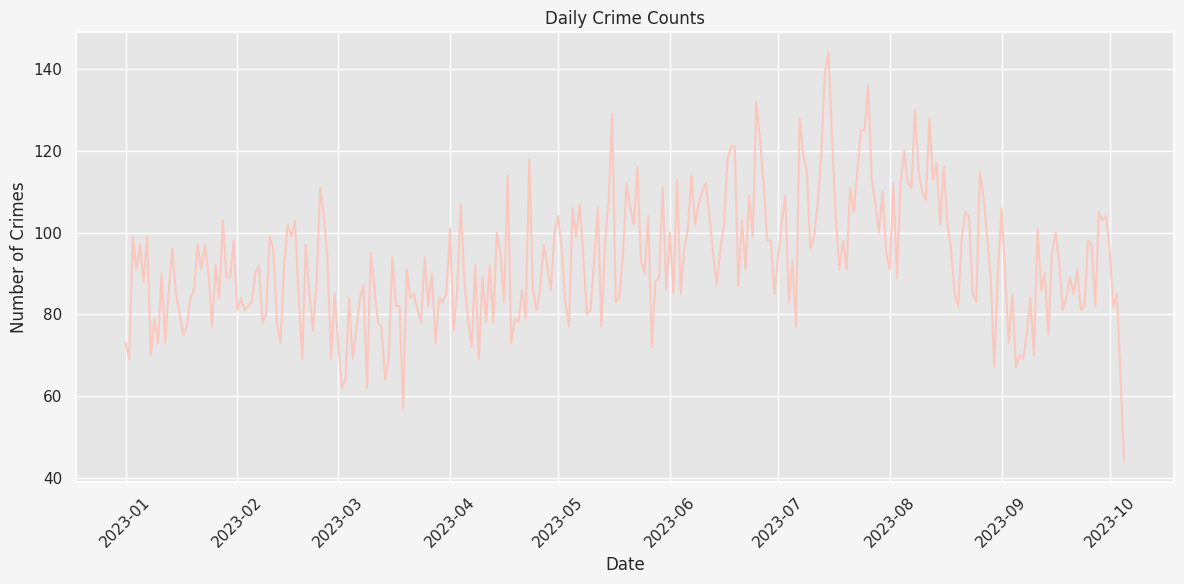

In [7]:

daily_counts = df['start_date'].dt.date.value_counts().sort_index()
weekly_counts = df['start_date'].dt.to_period('W').value_counts().sort_index()
monthly_counts = df['start_date'].dt.to_period('M').value_counts().sort_index()

# Daily
plt.figure(figsize=(12,6))
sns.lineplot(x=daily_counts.index, y=daily_counts.values, color = palette[0])
plt.title('Daily Crime Counts')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

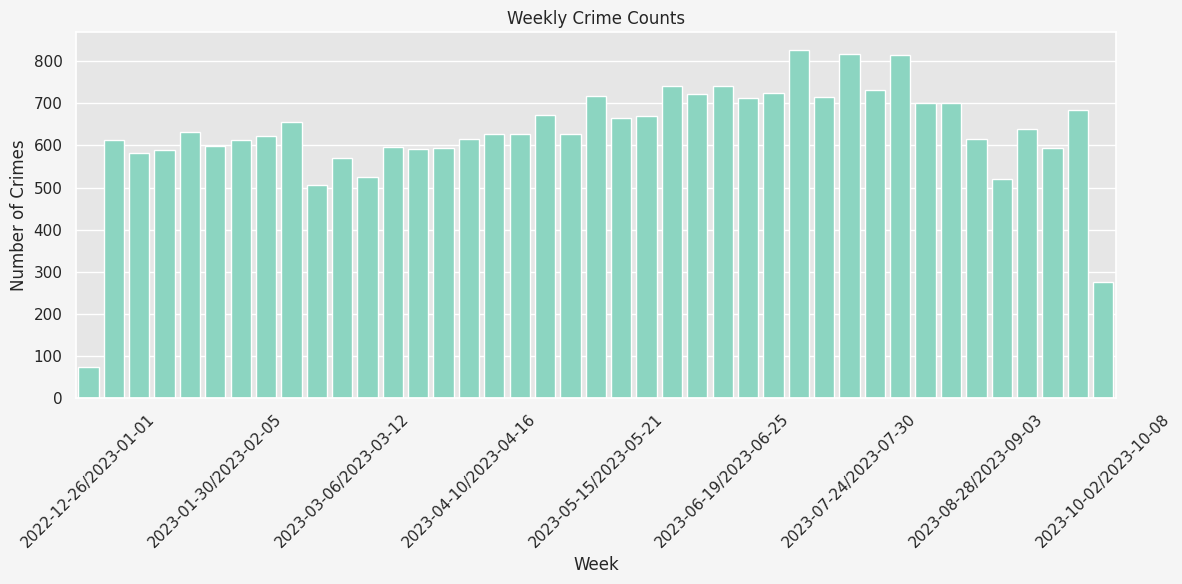

In [8]:
# Weekly
plt.figure(figsize=(12,6))
sns.barplot(x=weekly_counts.index.astype(str), y=weekly_counts.values, color=palette[1])
locs, labels = plt.xticks()
plt.xticks(locs[::5], weekly_counts.index.astype(str)[::5], rotation=45)

plt.title('Weekly Crime Counts')
plt.xlabel('Week')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.show()

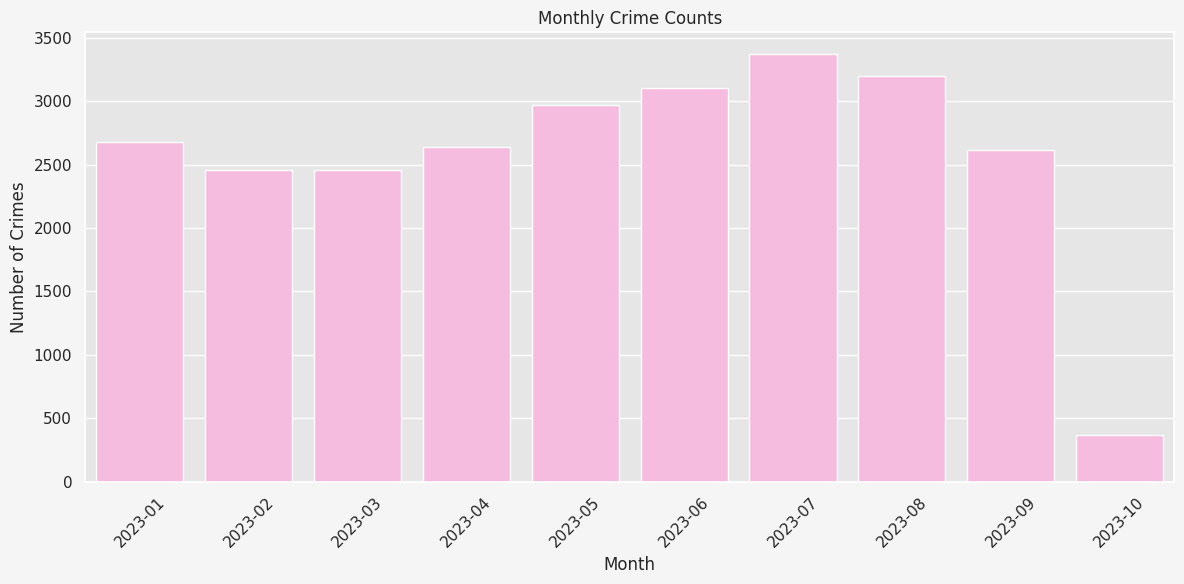

In [9]:
# Monthly
plt.figure(figsize=(12,6))
sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values,color=palette[2])
plt.title('Monthly Crime Counts')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

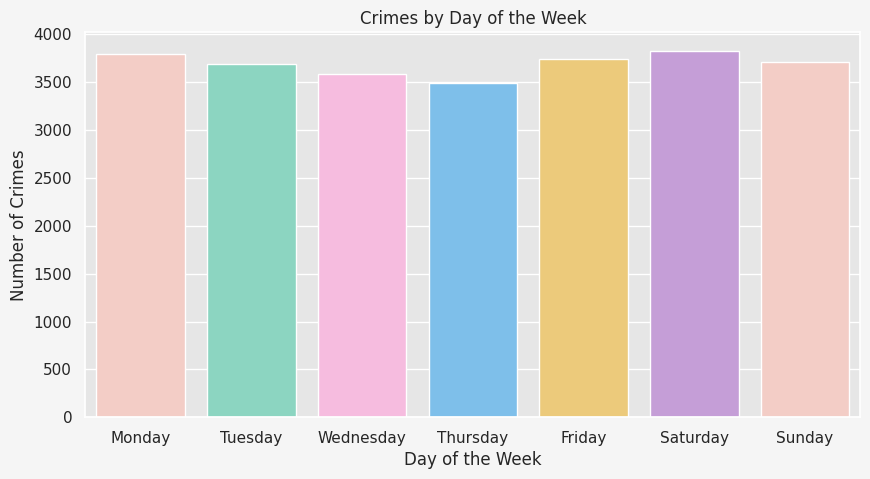

In [10]:
df['day_of_week'] = df['start_date'].dt.dayofweek
weekday_counts = df['day_of_week'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x=days, y=weekday_counts, palette=palette)
plt.title('Crimes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.show()

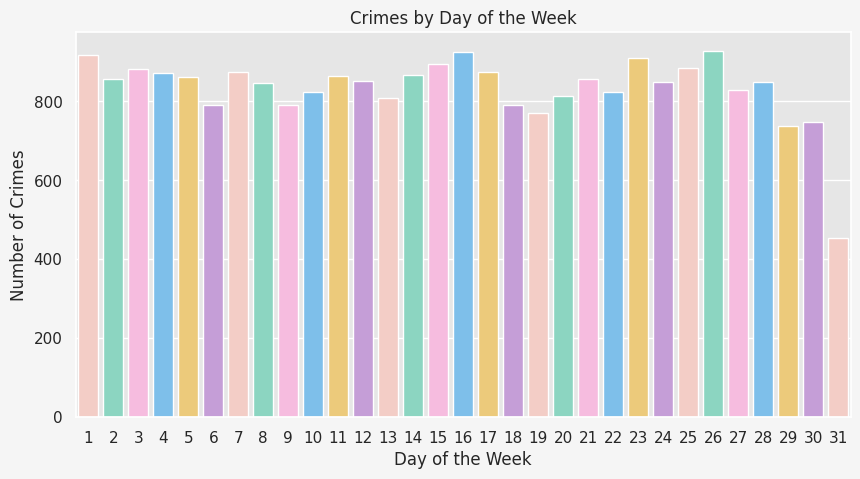

In [11]:
df['day_of_month'] = df['start_date'].dt.day
day_counts = df['day_of_month'].value_counts().sort_index()
# days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x=day_counts.index, y=day_counts, palette=palette)
plt.title('Crimes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.show()

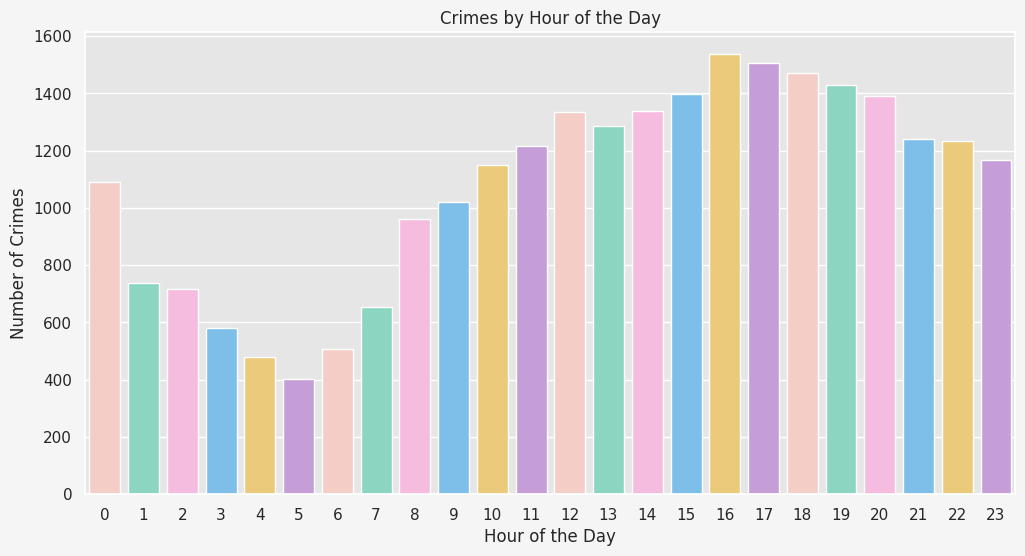

In [12]:
df['hour'] = df['start_date'].dt.hour
hourly_counts = df['hour'].value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=hourly_counts.index, y=hourly_counts, palette=palette)
plt.title('Crimes by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(ticks=range(24), rotation=0)
plt.show()

In [13]:
metro_lines = gpd.read_file('./data/dc-maps/maps/metro-lines.geojson')
atm = gpd.read_file('./data/dc-maps/maps/atm-banking.geojson')
banks = gpd.read_file('./data/dc-maps/maps/bank-locations.geojson')
gas = gpd.read_file('./data/dc-maps/maps/gas-stations.geojson')
hospitals = gpd.read_file('./data/dc-maps/maps/hospitals.geojson')
# benches = gpd.read_file('./data/dc-maps/maps/benches.geojson') # toomany
dc_boundary = gpd.read_file('./data/dc-maps/maps/dc-boundary.geojson')
district = gpd.read_file('./data/dc-maps/maps/district-mask.geojson')
libraries = gpd.read_file('./data/dc-maps/maps/libraries.geojson')
metro_stations=gpd.read_file('./data/dc-maps/maps/metro-station-entrances-district.geojson')
parks = gpd.read_file('./data/dc-maps/maps/national-parks.geojson')
museums = gpd.read_file('./data/dc-maps/maps/museums-in-dc.geojson')
police_stations = gpd.read_file('./data/dc-maps/maps/police-stations.geojson')
shuttle_bus = gpd.read_file('./data/dc-maps/maps/shuttle-bus-stops.geojson')
shopping_centers = gpd.read_file('./data/dc-maps/maps/shopping-centers.geojson')
camera = gpd.read_file('./data/dc-maps/maps/camera-enforcement-locations.geojson')
grocery=gpd.read_file('./data/dc-maps/maps/grocery-store-locations.geojson')
metro_bus = gpd.read_file('./data/dc-maps/maps/metro-bus-stops.geojson')
post_office = gpd.read_file('./data/dc-maps/maps/post-offices.geojson')
schools = gpd.read_file('./data/dc-maps/maps/public-schools.geojson')

In [14]:
def fishnet(geometry, step=0.01):
    bounds = geometry.bounds
    xmin,ymin,xmax,ymax=bounds
    result = []
    for i in np.arange(xmin, xmax, step):
        for j in np.arange(ymin, ymax, step):
            b = box(i, j, i+step, j+step)
            g = geometry.intersection(b)
            if g.is_empty:
                continue
            result.append(g)
    return result

# make crime_data a geopanda frame
df['geometry'] = gpd.points_from_xy(df['longitude'], df['latitude'])
crime_data = gpd.GeoDataFrame(df, crs="EPSG:4326")


polygon=dc_boundary['geometry'][0]
res=fishnet(polygon, 0.005)
nets=gpd.GeoDataFrame(geometry=res)
nets['index']=range(len(nets))

In [15]:
def count_close_building(crime_data, buildings, new_col_name='counts', max_distance=0.002):
    data=crime_data
    temp=data[['index','geometry']]
    buildings_location=buildings[['geometry']]

    # Find events within the buffered_museums
    # 1 degree is approximately 111 km;
    temp_buffered = gpd.sjoin_nearest( temp, buildings_location, how='left',max_distance=max_distance,distance_col='distance')
    temp_buffered=temp_buffered[~temp_buffered['index_right'].isnull()]

    counts=pd.DataFrame(temp_buffered.groupby('index').size().rename(new_col_name))

    temp_merged=temp.merge(counts,left_on='index', right_on='index', how='left').fillna(0)

    return temp_merged

In [16]:
temp=count_close_building(crime_data,museums,'museums_count')
crime_data.loc[:,'museums_count']=temp.loc[:,'museums_count']

col_name='gas'
temp=count_close_building(crime_data,gas,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='metro_bus'
temp=count_close_building(crime_data,metro_bus,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='atm'
temp=count_close_building(crime_data,atm,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='banks'
temp=count_close_building(crime_data,banks,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='grocery'
temp=count_close_building(crime_data,grocery,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='metro_stations'
temp=count_close_building(crime_data,metro_stations,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='post_office'
temp=count_close_building(crime_data,post_office,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='schools'
temp=count_close_building(crime_data,schools,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='libraries'
temp=count_close_building(crime_data,libraries,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='shuttle_bus'
temp=count_close_building(crime_data,shuttle_bus,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]



In [17]:
# PCA on the lat and lon to get 1d
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
crime_data['PCA_location']=pca.fit_transform(crime_data[['longitude','latitude']])

In [18]:
crime_data.columns

Index(['index', 'neighborhood_cluster', 'offense_group', 'census_tract',
       'longitude', 'end_date', 'offense_text', 'shift', 'district', 'yblock',
       'ward', 'year', 'offensekey', 'bid', 'sector', 'psa', 'ucr_rank',
       'block_group', 'voting_precinct', 'xblock', 'block', 'start_date',
       'ccn', 'offense', 'anc', 'report_date', 'method', 'location',
       'latitude', 'day_of_week', 'day_of_month', 'hour', 'geometry',
       'museums_count', 'gas', 'metro_bus', 'atm', 'banks', 'grocery',
       'metro_stations', 'post_office', 'schools', 'libraries', 'shuttle_bus',
       'PCA_location'],
      dtype='object')

# split data for task

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

encoded_offsen_type=le.fit_transform(crime_data['offense'])


In [21]:
crime_data['offense_type']=encoded_offsen_type

In [23]:
sel_cols=['index','PCA_location','psa','ward','day_of_week', 'hour', 'museums_count', 'gas',
       'metro_bus', 'atm', 'banks', 'grocery', 'metro_stations', 'post_office',
       'schools', 'libraries', 'shuttle_bus','offense_type']
crime_data[sel_cols]

,index,PCA_location,psa,ward,day_of_week,hour,museums_count,gas,metro_bus,atm,banks,grocery,metro_stations,post_office,schools,libraries,shuttle_bus,offense_type
0,0,-0.058103,704.0,8.0,3,16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1,0.006194,405.0,5.0,4,18,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,2,-0.016873,104.0,6.0,2,19,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
3,3,0.033277,303.0,1.0,6,21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8
4,4,0.026046,207.0,2.0,5,15,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25850,25850,-0.014775,506.0,5.0,5,17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
25851,25851,-0.024049,503.0,5.0,1,21,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7
25852,25852,-0.001408,102.0,6.0,2,9,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8
25853,25853,0.057628,203.0,3.0,1,18,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,8


In [24]:
le.classes_

array(['ARSON', 'ASSAULT W/DANGEROUS WEAPON', 'BURGLARY', 'HOMICIDE',
       'MOTOR VEHICLE THEFT', 'ROBBERY', 'SEX ABUSE', 'THEFT F/AUTO',
       'THEFT/OTHER'], dtype=object)

In [25]:
le.get_params(8)

{}

In [26]:
selection=crime_data[sel_cols]
selection.isnull()
# selection[selection.isnull()]

,index,PCA_location,psa,ward,day_of_week,hour,museums_count,gas,metro_bus,atm,banks,grocery,metro_stations,post_office,schools,libraries,shuttle_bus,offense_type
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25850,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
25851,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
25852,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
25853,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## task 1:
## given an crime incident(location&time), predict the type of crime


## Decision Tree

In [30]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score,f1_score

x_sel_cols=['PCA_location','ward','psa','day_of_week', 'hour', 'museums_count', 'gas',
       'metro_bus', 'atm', 'banks', 'grocery', 'metro_stations', 'post_office',
       'schools', 'libraries', 'shuttle_bus','index']
y_sel_cols=['offense_type','index']
x=crime_data[x_sel_cols].fillna(0).values

y=crime_data[y_sel_cols].values

print('all x data:',x.shape)
print('all y data:',y.shape)

x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.1, random_state=0)
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.1, random_state=0)

all x data: (25855, 17)
all y data: (25855, 2)


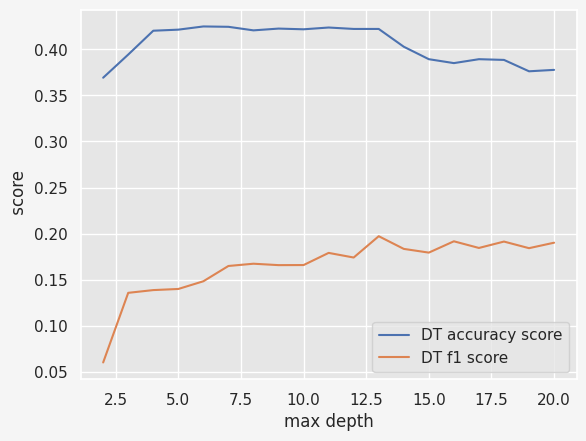

In [31]:
dt_acc_score=[]
dt_f1_score=[]
max_depths_range=range(2,21)
for depth in max_depths_range:
    depth=depth
    # use deceision tree to fit the data in regression
    dtmodel = DecisionTreeClassifier(random_state=0, max_depth=depth)
    dtmodel.fit(x_train[:,:-1],y_train[:,:-1])
    # use MAE to score the model
    y_val_pred=dtmodel.predict(x_val[:,:-1])
    dt_acc_score.append(accuracy_score(y_val[:,:-1],y_val_pred))
    dt_f1_score.append(f1_score(y_val[:,:-1],y_val_pred,average='macro'))

# plot the score
plt.plot(max_depths_range,dt_acc_score,label='DT accuracy score')
plt.plot(max_depths_range,dt_f1_score,label='DT f1 score')
plt.xlabel('max depth')
plt.ylabel(' score')
plt.legend()
# plt.savefig('./urban_computing/final_project_hp/figures/dt_score.png',dpi=300)
# plt.close()

best max depth is 11
1.579286635152557


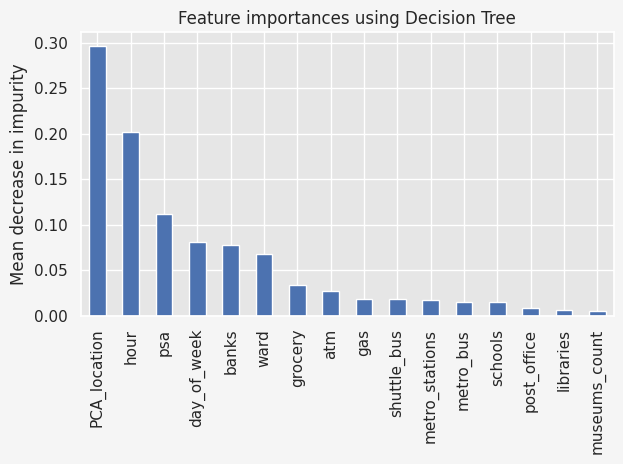

In [32]:
best_max_depth=11
print(f'best max depth is {best_max_depth}')
dtmodel = DecisionTreeClassifier(random_state=0, max_depth=best_max_depth)
dtmodel.fit(x_train[:,:-1],y_train[:,:-1])
y_test_pred=dtmodel.predict(x_test[:,:-1])
# use MAE to score the model
print(mean_absolute_error(y_test[:,:-1],y_test_pred))
# print the feature importance
forest_importances = pd.Series(dtmodel.feature_importances_, index=x_sel_cols[:-1])
# sort the feature importance
forest_importances.sort_values(ascending=False,inplace=True)
# choose the top 10 features
forest_importances=forest_importances[:20]
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using Decision Tree")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [33]:
accuracy_score(y_test[:,:-1],y_test_pred)

0.44005156854318866

In [34]:
prediction=pd.DataFrame(y_test,columns=['y_test_gt','index'])
prediction['y_pred']=y_test_pred

array([[<Axes: title={'center': 'y_test_gt'}>,
        <Axes: title={'center': 'y_pred'}>]], dtype=object)

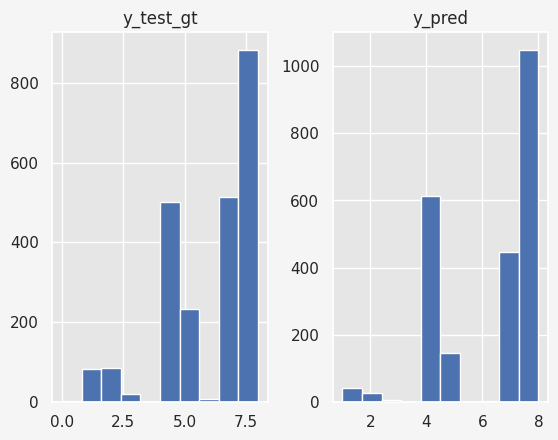

In [35]:
prediction[['y_test_gt','y_pred']].hist()

### ADABOOST

In [37]:
cat_cols=['ward','day_of_week']
x_sel_cols=['PCA_location','psa','day_of_week', 'hour', 'museums_count', 'gas',
       'metro_bus', 'atm', 'banks', 'grocery', 'metro_stations', 'post_office',
       'schools', 'libraries', 'shuttle_bus','index']
y_sel_cols=['offense_type','index']
x=crime_data[x_sel_cols].fillna(0).values
y=crime_data[y_sel_cols].values

enc = OneHotEncoder()
encoded=enc.fit_transform(crime_data[cat_cols]).toarray()
# for x, remove the first 2 columns
x=x[:,2:]
# append the encoded categorical columns
x=np.concatenate((encoded,x),axis=1)
print('all x data:',x.shape)
print('all y data:',y.shape)

x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.1, random_state=0)
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.1, random_state=0)

all x data: (25855, 30)
all y data: (25855, 2)


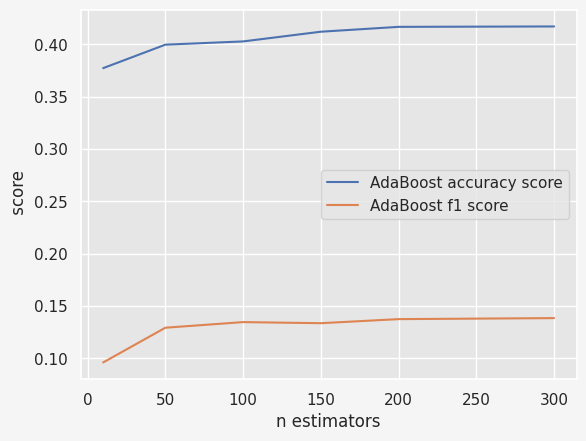

In [38]:
dt_acc_score=[]
dt_f1_score=[]
ns=[10,50,100,150,200,300]
for n_estimators in ns:

    # use deceision tree to fit the data in regression
    clf = AdaBoostClassifier(n_estimators=n_estimators, algorithm="SAMME",)
    clf.fit(x_train[:,:-1],y_train[:,:-1])
    # use MAE to score the model
    y_val_pred=clf.predict(x_val[:,:-1])
    dt_acc_score.append(accuracy_score(y_val[:,:-1],y_val_pred))
    dt_f1_score.append(f1_score(y_val[:,:-1],y_val_pred,average='macro'))

# plot the score
plt.plot(ns,dt_acc_score,label='AdaBoost accuracy score')
plt.plot(ns,dt_f1_score,label='AdaBoost f1 score')
plt.xlabel('n estimators')
plt.ylabel(' score')
plt.legend()
# plt.savefig('./final_project_hp/figures/dt_score.png',dpi=300)
# plt.close()

In [39]:
clf = AdaBoostClassifier(n_estimators=500,algorithm="SAMME",)
clf.fit(x_train[:,:-1],y_train[:,:-1])
y_test_pred=clf.predict(x_test[:,:-1])

print(accuracy_score(y_test[:,:-1],y_test_pred))

prediction=pd.DataFrame(y_test,columns=['y_test_gt','index'])
prediction['y_pred']=y_test_pred

0.41555651052857756


array([[<Axes: title={'center': 'y_test_gt'}>,
        <Axes: title={'center': 'y_pred'}>]], dtype=object)

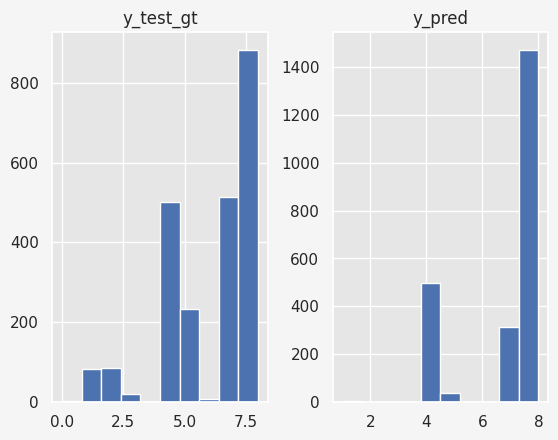

In [40]:
prediction[['y_test_gt','y_pred']].hist()